## Loading packages

In [1]:
import glob
import random
import os
import numpy as np
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import torch
import argparse
import itertools
from torch.utils.data import DataLoader
from torch.autograd import Variable
from trainer.utils import Resize, ToTensor, smooothing_loss
from torchvision.transforms import RandomAffine
from torchvision.transforms import RandomAffine, ToPILImage
from skimage import measure
from skimage import metrics
import cv2
import yaml
from torch.autograd import Variable
import torch.nn as nn
from torch.distributions.normal import Normal
import torch.nn.functional as F


/home/ftahmed/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the hyperparameter log
./MyHyPList.yaml contains all the hyperparameters we need for the training such as batch size, epoch size etc.

In [15]:
config_dir= './MyHyPList.yaml'
with open(config_dir, 'r') as stream:
    config= yaml.safe_load(stream)
    

## Abstract Dataset Class
We created the class as a map-style dataset reading with __getitem()__ and __len()__ methods and. The method getitem loading the data which is in .npy form, applies the transformations and finally split the key-value paired tensor as float32 datatype. 

In [62]:
class ImageDataset(Dataset):
    def __init__(self,root, noise_level, transforms_A=None):
        self.transforms_A = transforms.Compose(transforms_A)
        self.files_A = sorted(glob.glob("%s/A/*" % root))
        self.files_B = sorted(glob.glob("%s/B/*" % root))
        self.noise_level =noise_level
        
    def __getitem__(self, index):
        # if noise =0, A and B make same transform
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        item_A = self.transforms_A(np.load(self.files_A[index % len(self.files_A)]).astype(np.float32))
        
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        item_B = self.transforms_A(np.load(self.files_B[index % len(self.files_B)]).astype(np.float32))

                   
        return {'A': item_A, 'B': item_B}
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


class ValDataset(Dataset):
    def __init__(self, root,transforms_=None):
        self.transform_ = transforms.Compose(transforms_)
        self.files_A = sorted(glob.glob("%s/A/*" % root))
        self.files_B = sorted(glob.glob("%s/B/*" % root))
        
    def __getitem__(self, index):
        item_A = self.transform_(np.load(self.files_A[index % len(self.files_A)]).astype(np.float32))
        item_B = self.transform_(np.load(self.files_B[index % len(self.files_B)]).astype(np.float32))
        return {'A': item_A, 'B': item_B}
    def __len__(self):
        return max(len(self.files_A), len(self.files_B))
    

## Defining the data loader
For data augmentation, we have used __RandomAffine__ which will make random rotation, random translate and random scaling. 

In [51]:
level = config['noise_level']
transforms_A = [
    ToPILImage(),
    RandomAffine(
        degrees=level, translate=[0.02 * level, 0.02 * level], scale=[1 - 0.02 * level, 1 + 0.02 * level]
    ),
    ToTensor(),
    Resize(size_tuple=(config["size"], config["size"])),
]

Train_dataloader = DataLoader(
    ImageDataset(
        config["dataroot"],
        config['noise_level'],
        transforms_A=transforms_A,
    ),
    batch_size=config["batchSize"],
    shuffle=True,
)

val_transforms = (
    ToTensor(),
    Resize(size_tuple=(config["size"], config["size"])),
)

val_dataloader = DataLoader(
    ValDataset(
        config["val_dataroot"], transforms_=val_transforms
    ),
    batch_size=config["batchSize"],
    shuffle=False,
)


## Display a random batch of training patches.

True

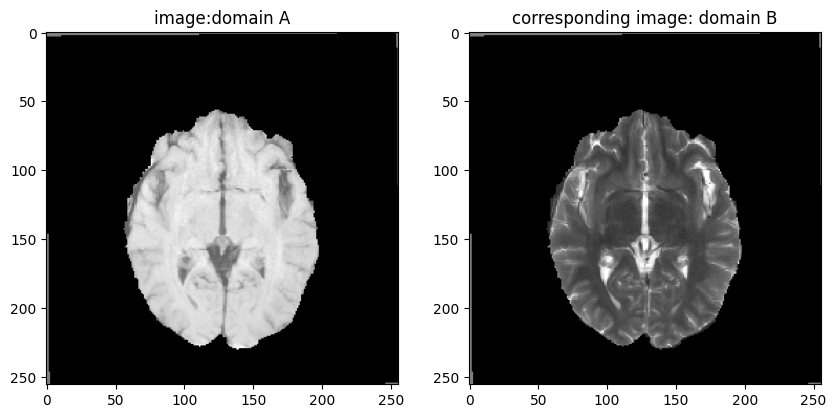

In [56]:
Imagepair= next(iter(Train_dataloader))
ImageA= Imagepair['A']
ImageB= Imagepair['B']
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(10,5))
s=ax[0].imshow(ImageA.squeeze(), cmap= 'gray')
ax[0].set_title('image:domain A')
s=ax[1].imshow(ImageB.squeeze(), cmap= 'gray')
ax[1].set_title('corresponding image: domain B')
ImageA = 255 * ((ImageA.detach().cpu().numpy().squeeze() + 1) / 2)
ImageB= 255 * ((ImageB.detach().cpu().numpy().squeeze() + 1) / 2)
cv2.imwrite(config["train_image"] + 'Image:domain A' + ".png", ImageA)
cv2.imwrite(config["train_image"] + 'Image:domain B' + ".png", ImageB)


In [54]:
ImageA.min(), ImageA.max()

(0.0, 253.06818)

## Generator and Discriminator module
we have used GAN architecture which combines a single generator with a discriminator. The Generator network can be seen  of three parts: head, body and tail. The head part consists of two down-sampling convolution blocks, while the body includes nine residual blocks sequentially , and finally the tail part has two up-sampling deconvolutional blocks to get the input image dimension back.

In [7]:
import torch.nn.functional as F
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        conv_block = [nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.InstanceNorm2d(in_features),
                      nn.ReLU(inplace=True),
                      nn.ReflectionPad2d(1),
                      nn.Conv2d(in_features, in_features, 3),
                      nn.InstanceNorm2d(in_features)]

        self.conv_block = nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)


class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Initial convolution block
        model_head = [nn.ReflectionPad2d(3),
                      nn.Conv2d(input_nc, 64, 7),
                      nn.InstanceNorm2d(64),
                      nn.ReLU(inplace=True)]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model_head += [nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                           nn.InstanceNorm2d(out_features),
                           nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        model_body = []
        for _ in range(n_residual_blocks):
            model_body += [ResidualBlock(in_features)]

        # Upsampling
        model_tail = []
        out_features = in_features // 2
        for _ in range(2):
            model_tail += [nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                           nn.InstanceNorm2d(out_features),
                           nn.ReLU(inplace=True)]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model_tail += [nn.ReflectionPad2d(3),
                       nn.Conv2d(64, output_nc, 7),
                       nn.Tanh()]

        self.model_head = nn.Sequential(*model_head)
        self.model_body = nn.Sequential(*model_body)
        self.model_tail = nn.Sequential(*model_tail)

    def forward(self, x):
        x = self.model_head(x)
        x = self.model_body(x)
        x = self.model_tail(x)

        return x


class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [nn.Conv2d(input_nc, 64, 4, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(64, 128, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(128),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(128, 256, 4, stride=2, padding=1),
                  nn.InstanceNorm2d(256),
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv2d(256, 512, 4, padding=1),
                  nn.InstanceNorm2d(512),
                  nn.LeakyReLU(0.2, inplace=True)]

        # FCN classification layer
        model += [nn.Conv2d(512, 1, 4, padding=1)]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)
    
    

## Summary of the dimensions change

In [8]:
from torchsummary import summary

model = Generator(1,1,n_residual_blocks=9)
summary(model, (1, 256, 256))

model = Discriminator(2)
summary(model, (2, 256, 256))


Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 256, 64, 64]         --
|    └─ReflectionPad2d: 2-1                   [-1, 1, 262, 262]         --
|    └─Conv2d: 2-2                            [-1, 64, 256, 256]        3,200
|    └─InstanceNorm2d: 2-3                    [-1, 64, 256, 256]        --
|    └─ReLU: 2-4                              [-1, 64, 256, 256]        --
|    └─Conv2d: 2-5                            [-1, 128, 128, 128]       73,856
|    └─InstanceNorm2d: 2-6                    [-1, 128, 128, 128]       --
|    └─ReLU: 2-7                              [-1, 128, 128, 128]       --
|    └─Conv2d: 2-8                            [-1, 256, 64, 64]         295,168
|    └─InstanceNorm2d: 2-9                    [-1, 256, 64, 64]         --
|    └─ReLU: 2-10                             [-1, 256, 64, 64]         --
├─Sequential: 1-2                             [-1, 256, 64, 64]         --
|    └─R

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 1, 30, 30]           --
|    └─Conv2d: 2-1                       [-1, 64, 128, 128]        2,112
|    └─LeakyReLU: 2-2                    [-1, 64, 128, 128]        --
|    └─Conv2d: 2-3                       [-1, 128, 64, 64]         131,200
|    └─InstanceNorm2d: 2-4               [-1, 128, 64, 64]         --
|    └─LeakyReLU: 2-5                    [-1, 128, 64, 64]         --
|    └─Conv2d: 2-6                       [-1, 256, 32, 32]         524,544
|    └─InstanceNorm2d: 2-7               [-1, 256, 32, 32]         --
|    └─LeakyReLU: 2-8                    [-1, 256, 32, 32]         --
|    └─Conv2d: 2-9                       [-1, 512, 31, 31]         2,097,664
|    └─InstanceNorm2d: 2-10              [-1, 512, 31, 31]         --
|    └─LeakyReLU: 2-11                   [-1, 512, 31, 31]         --
|    └─Conv2d: 2-12                      [-1, 1, 30, 30]         

## Train and test module

In [59]:
import argparse
import itertools
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os
from trainer.utils import LambdaLR
from trainer.utils import weights_init_normal,get_config
# from .datasets import ImageDataset,ValDataset
from Model.CycleGan import *
from trainer.utils import Resize,ToTensor,smooothing_loss
from trainer.utils import Logger
# from .reg import Reg
from torchvision.transforms import RandomAffine,ToPILImage
# from .transformer import Transformer_2D
from skimage import metrics
import numpy as np
import cv2
    

class Trainer():
    def __init__(self, config, Train_dataloader, val_dataloader):
        super().__init__()
        self.config = config
        ## def networks
        self.netG_A2B = Generator(config['input_nc'], config['output_nc']).cuda()
        self.netD_B = Discriminator(config['input_nc']).cuda()
        
        ## def optimizer
        self.optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=config['lr'], betas=(0.5, 0.999))
        self.optimizer_G = torch.optim.Adam(self.netG_A2B.parameters(), lr=config['lr'], betas=(0.5, 0.999))
            
        # def lossess
        self.MSE_loss = torch.nn.MSELoss()
        self.L1_loss = torch.nn.L1Loss()
        self.BCE_loss= torch.nn.BCEWithLogitsLoss()
        

        # Inputs & targets memory allocation
        Tensor = torch.cuda.FloatTensor if config['cuda'] else torch.Tensor
        self.input_A = Tensor(config['batchSize'], config['input_nc'], config['size'], config['size'])
        self.input_B = Tensor(config['batchSize'], config['output_nc'], config['size'], config['size'])
        self.target_real = Variable(Tensor(1,1).fill_(1.0), requires_grad=False)
        self.target_fake = Variable(Tensor(1,1).fill_(0.0), requires_grad=False)

        #Dataset loader
        self.dataloader = Train_dataloader
        self.val_data = val_dataloader

 
      
        
    def train(self):
        ###### Training ######
        for epoch in range(self.config['epoch'], self.config['n_epochs']):
            for i, batch in enumerate(self.dataloader):
                # Set model input
                real_A = Variable(self.input_A.copy_(batch['A']))
                real_B = Variable(self.input_B.copy_(batch['B']))
                
                self.optimizer_G.zero_grad()
                fake_B = self.netG_A2B(real_A)
                loss_L1 = self.L1_loss(fake_B, real_B) * self.config['P2P_lamda']
                # gan loss: 
                pred_fake = self.netD_B(fake_B)
                loss_GAN_A2B = self.MSE_loss(pred_fake, self.target_real) * self.config['GenAdv_lamda']

                # Total loss
                toal_loss = loss_L1+loss_GAN_A2B
                toal_loss.backward()
                self.optimizer_G.step()
                
                ###### Discriminator B ######
                self.optimizer_D_B.zero_grad()
                with torch.no_grad():
                    fake_B = self.netG_A2B(real_A)
                pred_fake0 = self.netD_B(fake_B) * self.config['DisAdv_lambda']
                pred_real = self.netD_B(real_B) * self.config['DisAdv_lambda']
                loss_D_B = self.MSE_loss(pred_fake0, self.target_fake)+self.MSE_loss(pred_real, self.target_real)
                loss_D_B.backward()
                self.optimizer_D_B.step()
                ###################################

    #         # Save models checkpoints
            if not os.path.exists(self.config["save_root"]):
                os.makedirs(self.config["save_root"])
            torch.save(self.netG_A2B.state_dict(), self.config['save_root'] +'Epoch_'+str(epoch)+ '_netG_A2B.pth')
            # torch.save(self.netD_B.state_dict(), self.config['save_root']+'netD_B.pth')
            
            
            #############val###############
            with torch.no_grad():
                MAE = 0
                num = 0
                for i, batch in enumerate(self.val_data):
                    real_A = Variable(self.input_A.copy_(batch['A']))
                    real_B = Variable(self.input_B.copy_(batch['B'])).detach().cpu().numpy().squeeze()
                    fake_B = self.netG_A2B(real_A).detach().cpu().numpy().squeeze()
                    mae = self.MAE(fake_B,real_B)
                    MAE += mae
                    num += 1


                print (f'Epoch:{epoch}\t Val MAE:{MAE/num}')
                Imagepair= next(iter(self.val_data))
                real_A = Variable(self.input_A.copy_(Imagepair['A']))
                real_B = Variable(self.input_B.copy_(Imagepair['B'])).detach().cpu().numpy().squeeze()
                fake_B = self.netG_A2B(real_A).detach().cpu().numpy().squeeze()
                fig, ax = plt.subplots(1,3,figsize=(15,5))
                s=ax[0].imshow(real_A.detach().cpu().numpy().squeeze(), cmap= 'gray')
                ax[0].set_title('image:domain A')
                s=ax[1].imshow(real_B.squeeze(), cmap= 'gray')
                ax[1].set_title('image: domain B')
                s=ax[2].imshow(fake_B.squeeze(), cmap= 'gray')
                ax[2].set_title('Fake image: domain B')
                plt.show()
                
                    
                         
    def test(self,epoch):
        self.netG_A2B.load_state_dict(torch.load(self.config['save_root'] +'Epoch_'+str(epoch)+ '_netG_A2B.pth'))
        with torch.no_grad():
                MAE = 0
                PSNR = 0
                SSIM = 0
                num = 0
                for i, batch in enumerate(self.val_data):
                    real_A = Variable(self.input_A.copy_(batch['A']))
                    real_B = Variable(self.input_B.copy_(batch['B'])).detach().cpu().numpy().squeeze()
                    
                    fake_B = self.netG_A2B(real_A)
                    fake_B = fake_B.detach().cpu().numpy().squeeze()                                                 
                    mae = self.MAE(fake_B,real_B)
                    psnr = self.PSNR(fake_B,real_B)
                    ssim = metrics.structural_similarity(fake_B,real_B, data_range=1.0)
                    MAE += mae
                    PSNR += psnr
                    SSIM += ssim 
                    num += 1
                    real_A = 255 * ((real_A.detach().cpu().numpy().squeeze() + 1) / 2)
                    image_FB = 255 * ((fake_B + 1) / 2)
                    image_RB= 255 * ((real_B + 1) / 2)
                    if not os.path.exists(self.config["image_save"]):
                        os.makedirs(self.config["image_save"])
                    if np.mod(num,100)==0:
                        
                        cv2.imwrite(self.config["image_save"] + 'Input'+str(num) + ".png", real_A)
                        cv2.imwrite(self.config["image_save"] + 'NetOut_'+str(num) + ".png", image_FB)
                        cv2.imwrite(self.config["image_save"] + 'GT_'+str(num) + ".png", image_RB)
                    
                print ('MAE:',MAE/num)
                print ('PSNR:',PSNR/num)
                print ('SSIM:',SSIM/num)
    
    def PSNR(self,fake,real):
       x,y = np.where(real!= -1)# Exclude background
       mse = np.mean(((fake[x][y]+1)/2. - (real[x][y]+1)/2.) ** 2 )
       if mse < 1.0e-10:
          return 100
       else:
           PIXEL_MAX = 1
           return 20 * np.log10(PIXEL_MAX / np.sqrt(mse))
            
            
    def MAE(self,fake,real):
        x,y = np.where(real!= -1)  # Exclude background
        mae = np.abs(fake[x,y]-real[x,y]).mean()
        return mae/2     #from (-1,1) normaliz  to (0,1)


## Creating Trainer Object

In [60]:
Pix2PixTrain= Trainer(config,Train_dataloader, val_dataloader)


Epoch:21	 Val MAE:0.11568389256717637


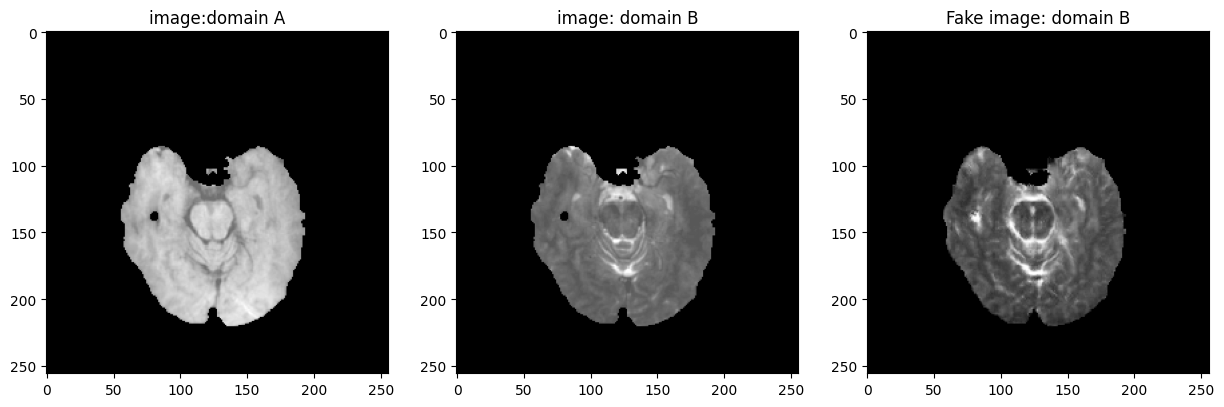

Epoch:22	 Val MAE:0.11275076404369126


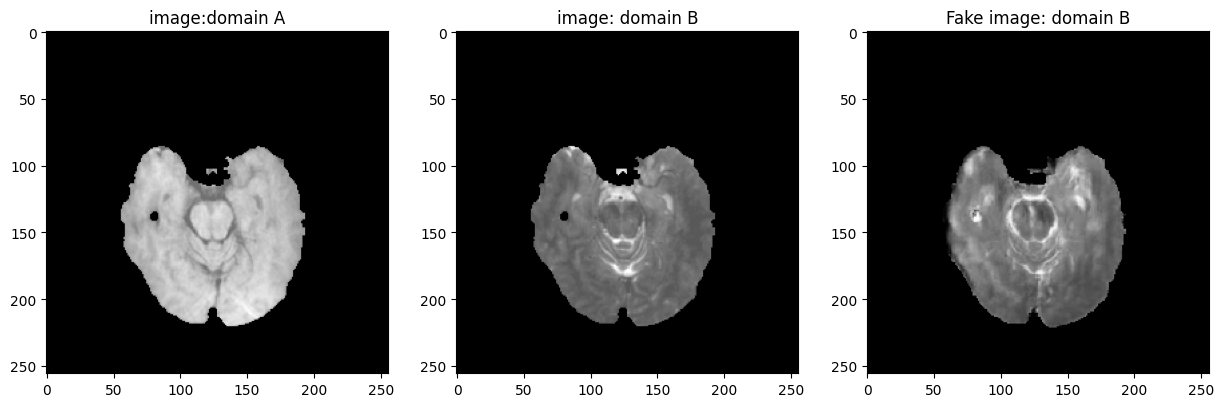

Epoch:23	 Val MAE:0.0968815432327877


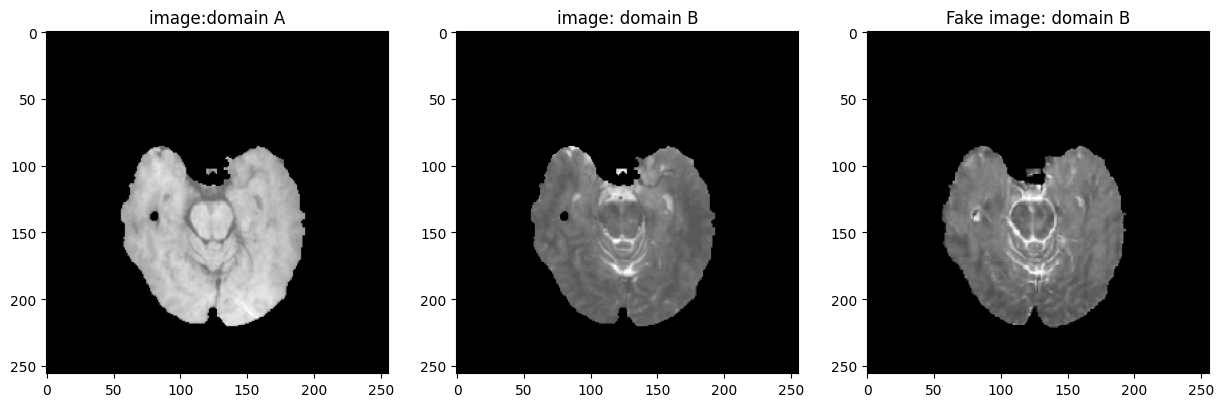

Epoch:24	 Val MAE:0.10456551626945536


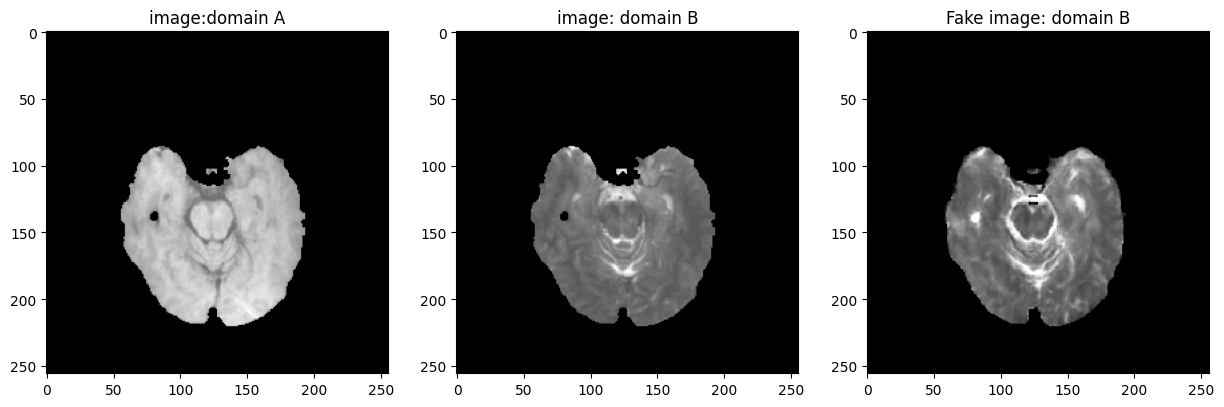

Epoch:25	 Val MAE:0.10833690113698442


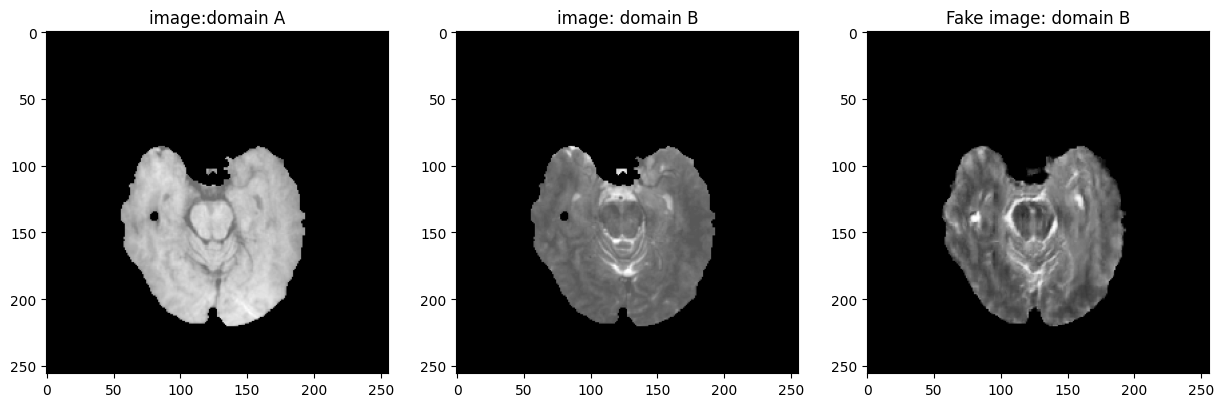

Epoch:26	 Val MAE:0.1087610616038243


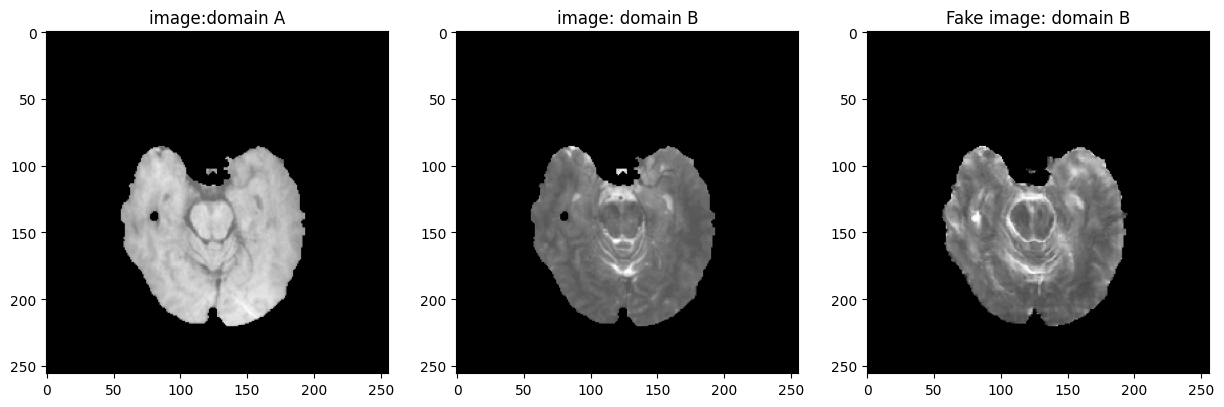

Epoch:33	 Val MAE:0.13196112745208666


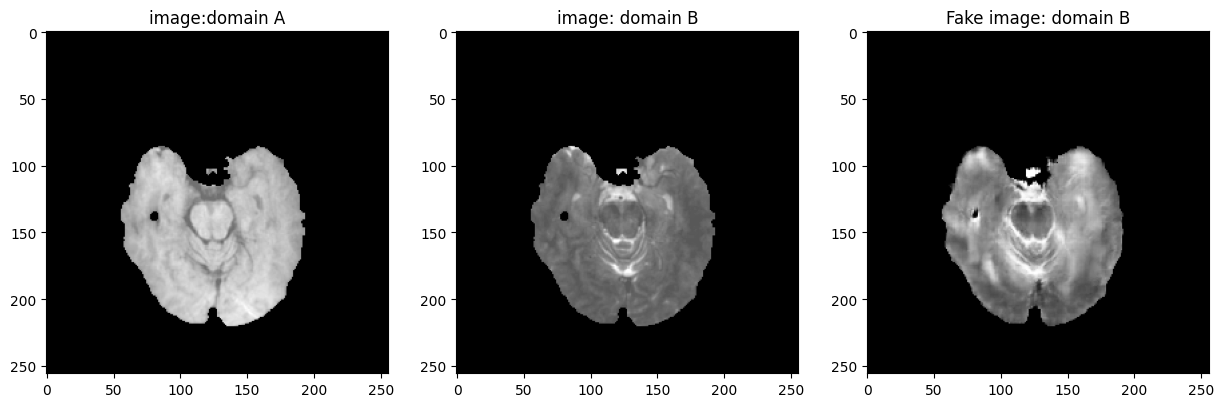

Epoch:34	 Val MAE:0.10090300073109877


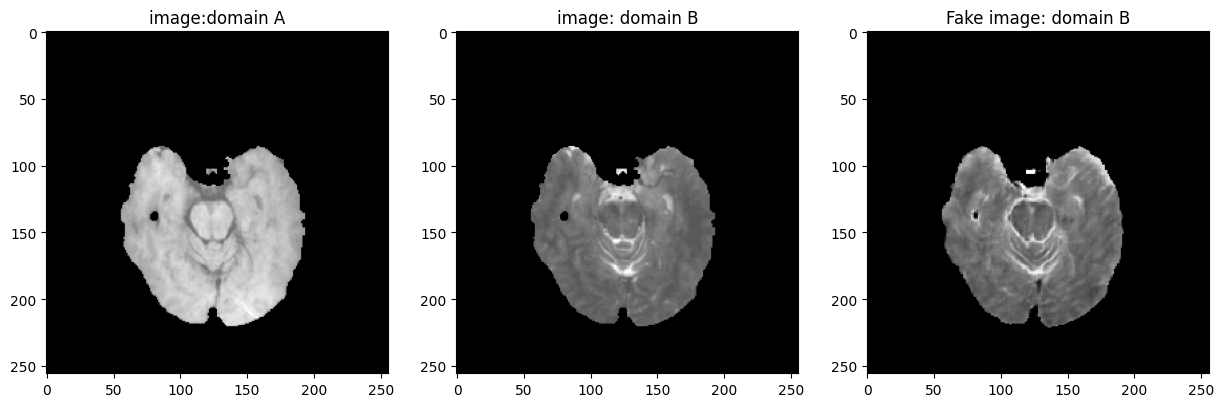

Epoch:35	 Val MAE:0.1057468736738277


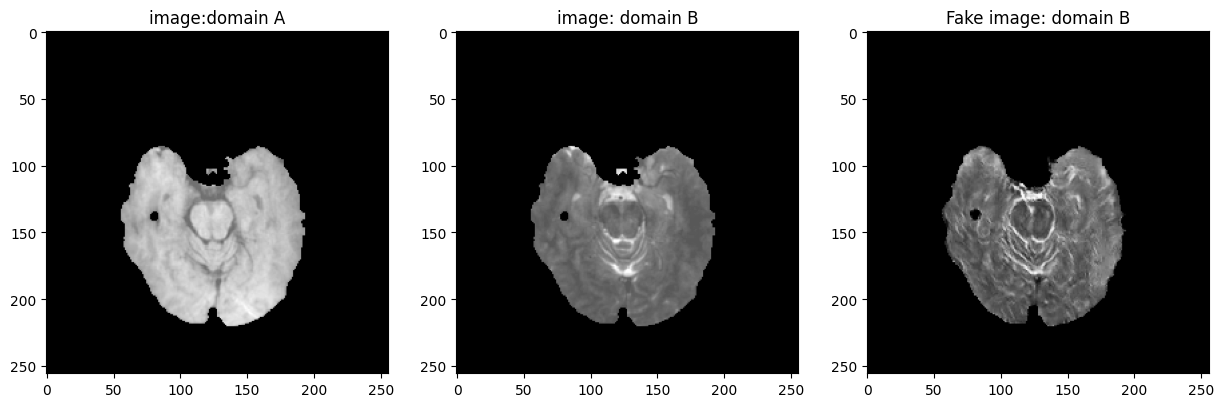

Epoch:36	 Val MAE:0.10473873076261953


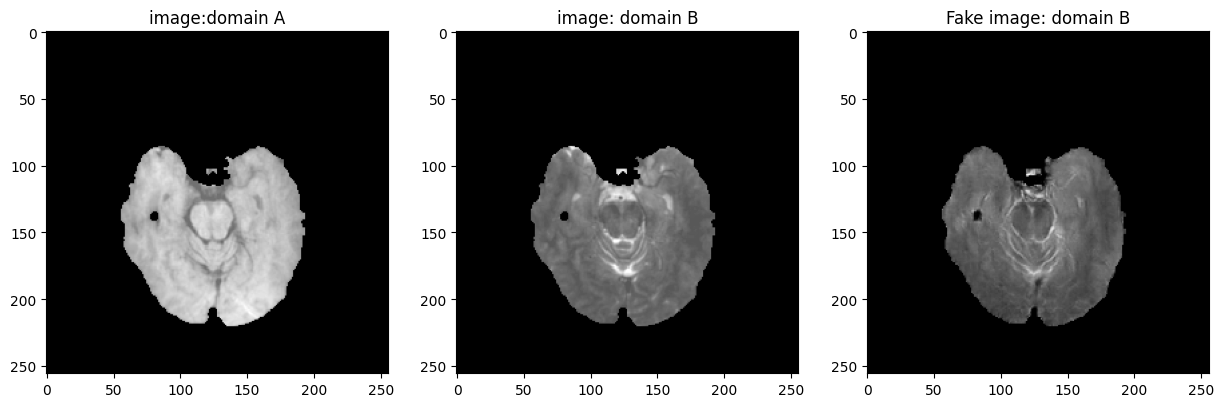

Epoch:37	 Val MAE:0.09910769193083979


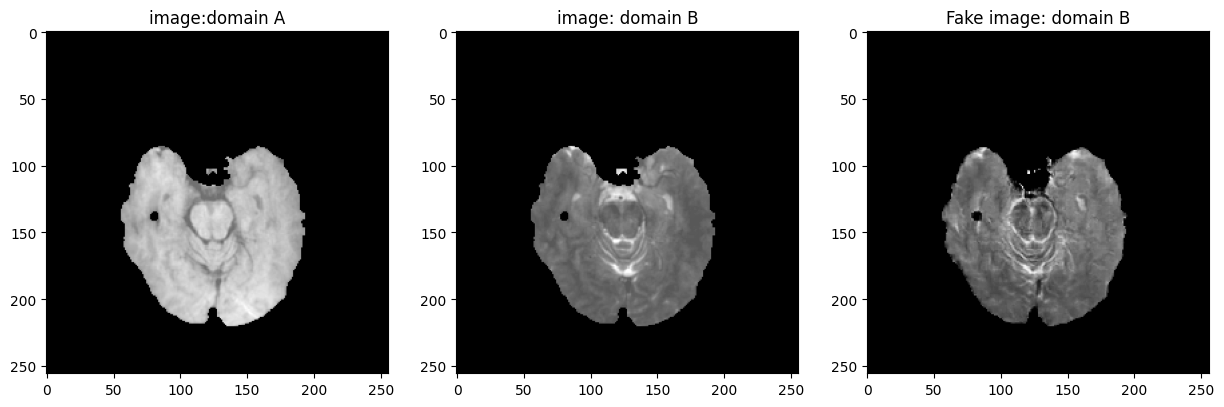

Epoch:38	 Val MAE:0.10177987385638214


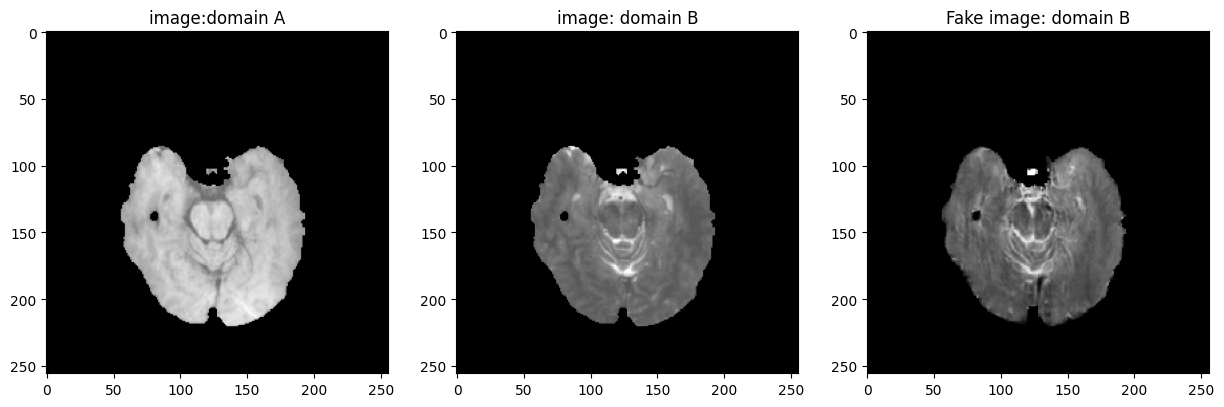

Epoch:42	 Val MAE:0.09827882115496323


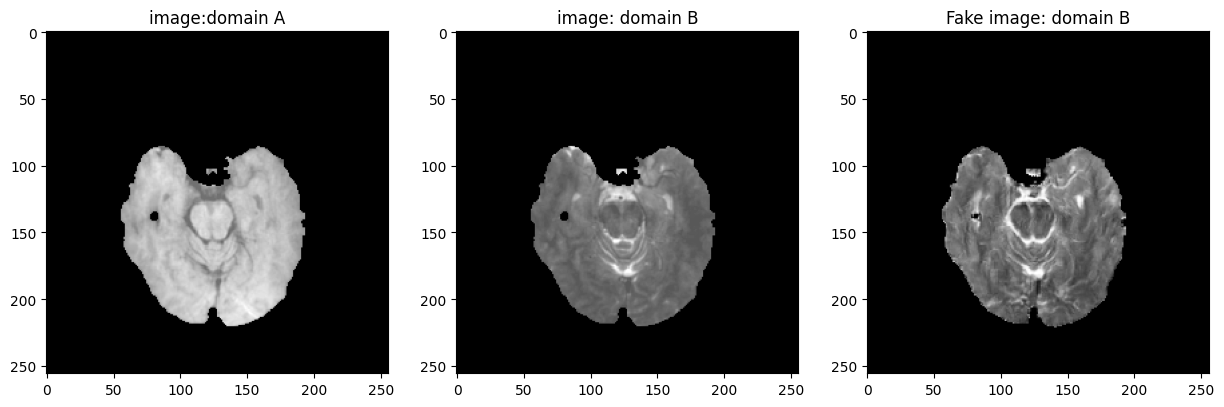

Epoch:43	 Val MAE:0.09274603802380928


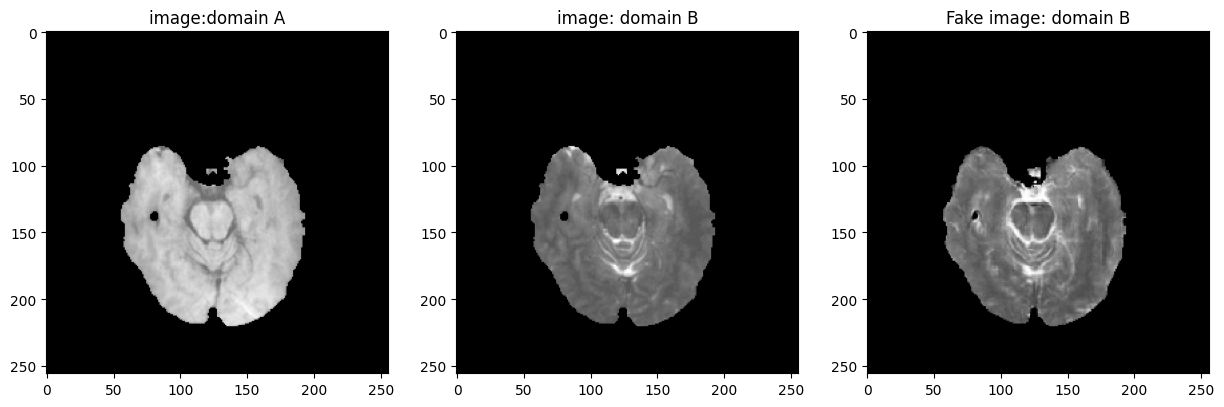

Epoch:44	 Val MAE:0.09876144736578378


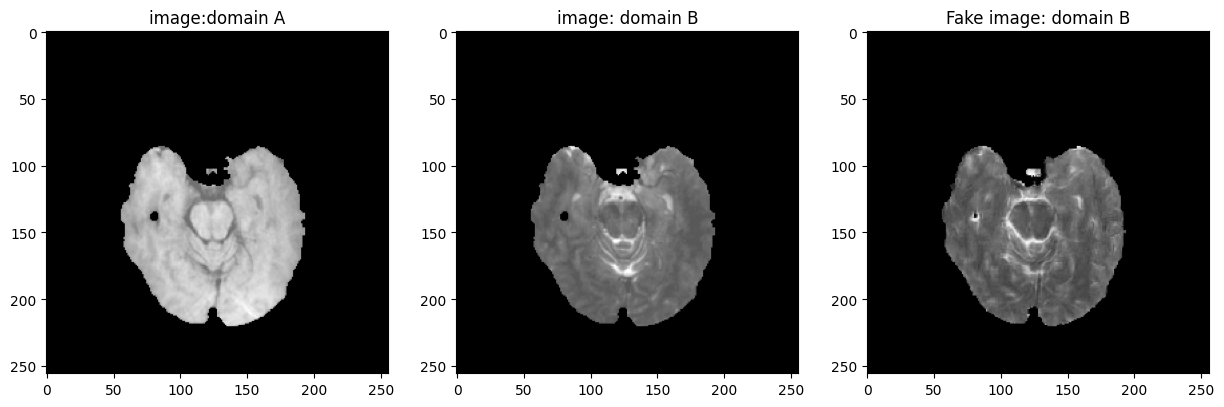

Epoch:45	 Val MAE:0.09603265711242177


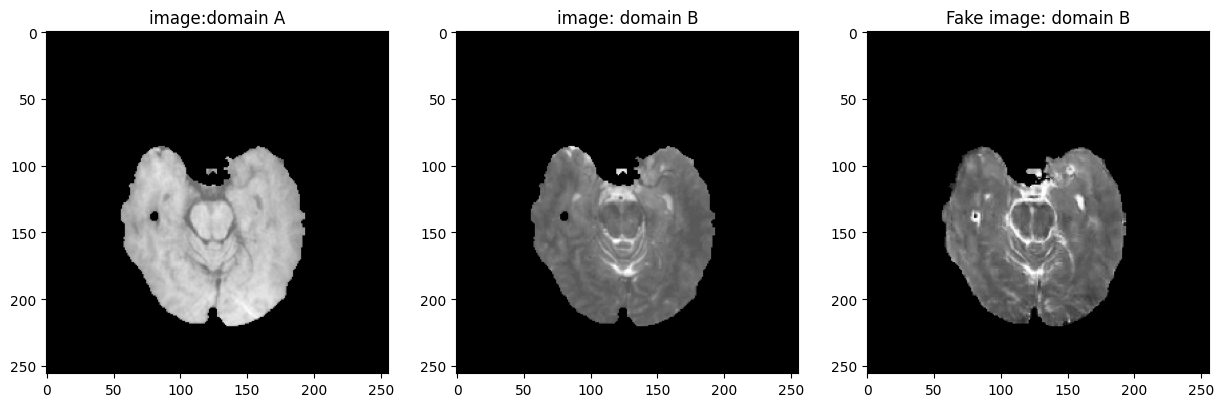

Epoch:46	 Val MAE:0.09836126940111474


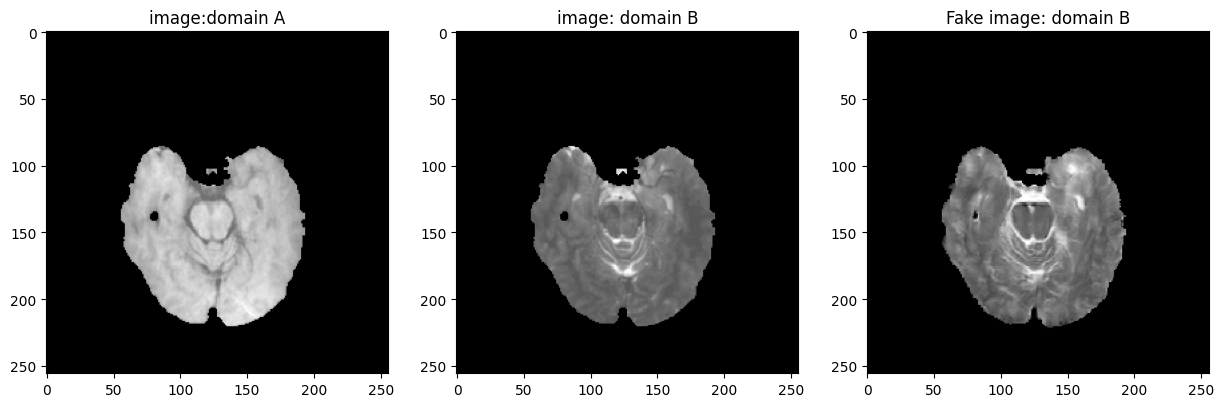

Epoch:47	 Val MAE:0.092186853037371


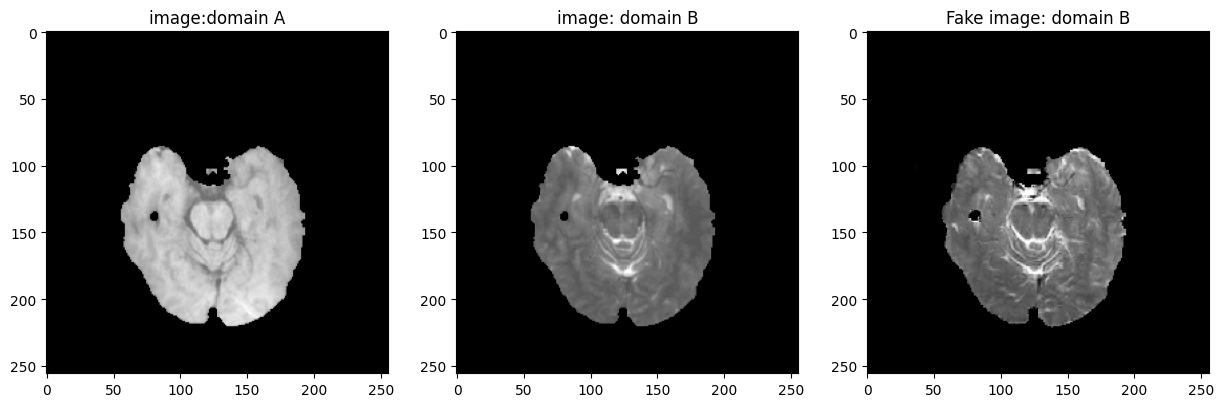

Epoch:48	 Val MAE:0.09852313614101149


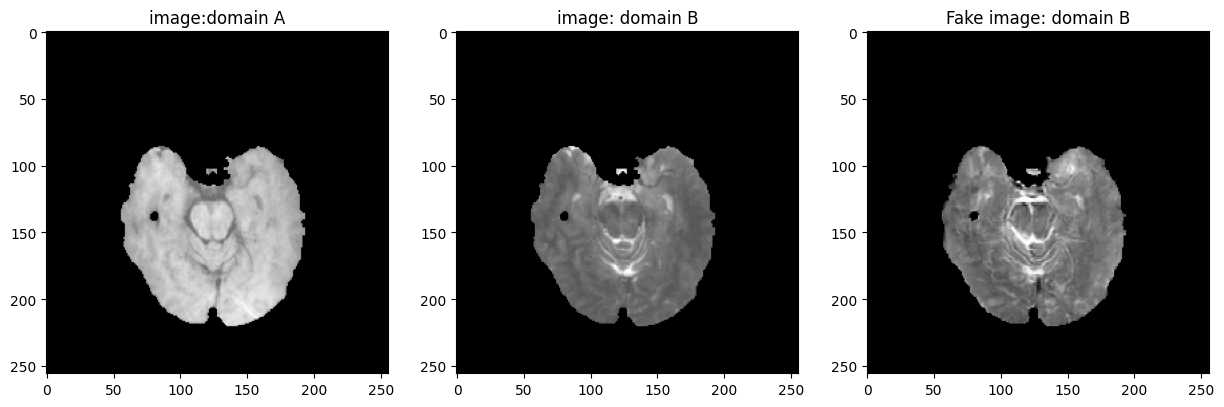

Epoch:49	 Val MAE:0.09036371965582173


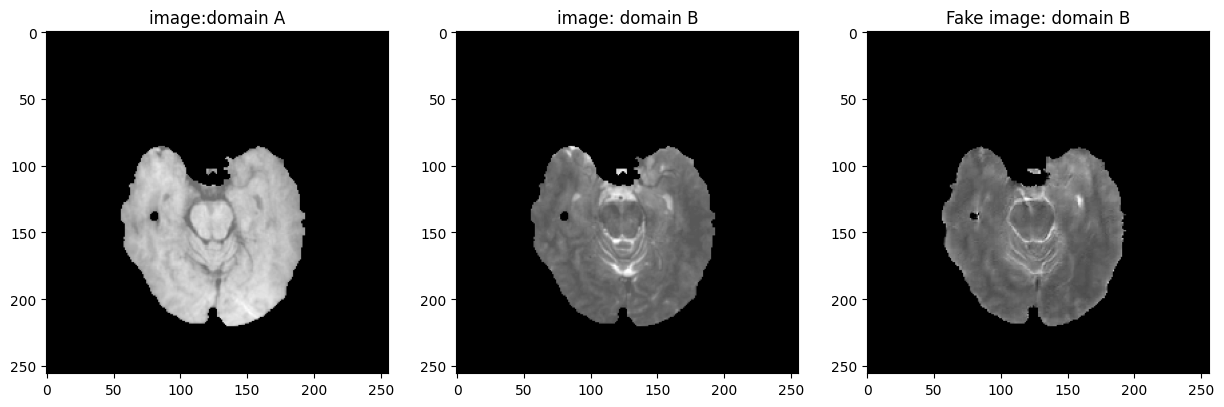

In [11]:
Pix2PixTrain.train()


## Model Inference

In [61]:
Pix2PixTrain.test()


MAE: 0.09603265711242177
PSNR: 22.199480268882297
SSIM: 0.8020072848339223


## Quantitative comparison

In [67]:
import torch
from piq import ssim, psnr

Epoch= 49
# model_path= '/home/ftahmed/Reg-GAN/NC+R/model_L2/' +'Epoch_'+str(epoch)+ '_netG_A2B.pth'
model_path= '/home/ftahmed/Reg-GAN/NC+R/model_L1/netG_A2B.pth'
netG_A2B = Generator(config['input_nc'], config['output_nc']).cuda()
netG_A2B.load_state_dict(torch.load(model_path))

Tensor = torch.cuda.FloatTensor if config['cuda'] else torch.Tensor
input_A = Tensor(config['batchSize'], config['input_nc'], config['size'], config['size'])
input_B = Tensor(config['batchSize'], config['output_nc'], config['size'], config['size'])
SsimValL1=[]
with torch.no_grad():
    for i, batch in enumerate(val_dataloader):
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))
        fake_B = netG_A2B(real_A)
        real_B= (real_B-real_B.min())/(real_B.max()-real_B.min())
        fake_B= (fake_B-fake_B.min())/(fake_B.max()-fake_B.min())
        SSIM= ssim(fake_B, real_B)
        SsimValL1.append(SSIM.detach().cpu().numpy().squeeze())

In [68]:
np.save('SsimValL2.npy', SsimValL2)
np.save('SsimValL1.npy', SsimValL1)

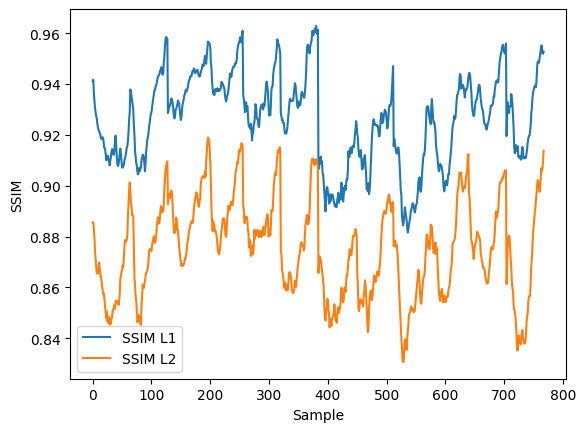

In [69]:
from matplotlib import pyplot as plt
plt.plot(SsimValL1, label='SSIM L1')
plt.plot(SsimValL2, label='SSIM L2')
plt.legend()
plt.xlabel('Sample')
plt.ylabel('SSIM')
plt.savefig('graph.png')